# An Application of Deep Reinforcement Learning to Algorithmic Trading

By Thibaut Théatea, Damien Ernsta

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

In [12]:
# %run datadownloader.py

In [13]:
aapl_training = pd.read_csv('data/AAPL_2012-01-01_2017-12-31.csv').set_index('Date')
aapl_validation = pd.read_csv('data/AAPL_2016-01-01_2017-12-31.csv').set_index('Date')
aapl_test = pd.read_csv('data/AAPL_2017-12-31_2019-12-31.csv').set_index('Date')
aapl_training.head()

,Close,High,Low,Open,Volume
Date,,,,,
2012-01-03,14.686786,14.732143,14.607143,14.621429,302220800
2012-01-04,14.765714,14.810000,14.617143,14.642857,260022000
2012-01-05,14.929643,14.948214,14.738214,14.819643,271269600
2012-01-06,15.085714,15.098214,14.972143,14.991786,318292800
2012-01-09,15.061786,15.276786,15.048214,15.196429,394024400


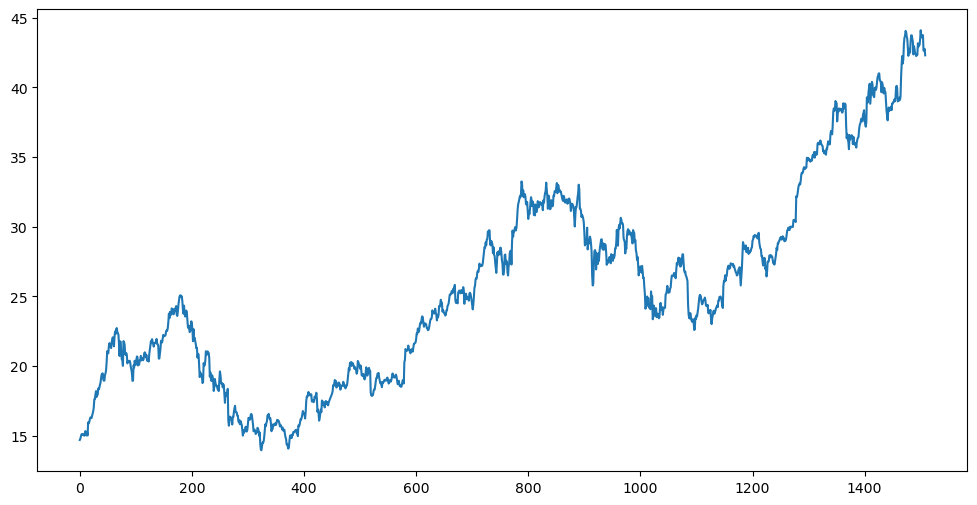

In [14]:
plt.figure(figsize=(12, 6))
plt.plot(np.arange(len(aapl_training['Close'])),aapl_training['Close'])
plt.show()